In [362]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB as mnb
import brewer2mpl as b2mpl
%matplotlib inline

sns.set_style('ticks')
sns.set_context('talk')
colors = b2mpl.get_map('Set1', 'Qualitative', 9).mpl_colors


In [381]:
# get raw data
with open('vocabulary.txt') as f:
    vocab = {i: line.strip('\n') for i, line in enumerate(f)}
nwords = len(vocab.keys())

with open('newsgrouplabels.txt') as f:
    nglabels = {i: line.strip('\n') for i, line in enumerate(f)}
nngs = len(nglabels.keys())

# make 0-based but not the actual word counts
y_train = np.genfromtxt('train.label') - 1
y_test = np.genfromtxt('test.label') - 1
X_train = np.genfromtxt('train.data')
X_test = np.genfromtxt('test.data')
X_train[:, 0:2] -= 1
X_test[:, 0:2] -= 1

X_train = sparse.csr_matrix((X_train[:, 2],
                             (X_train[:, 0], X_train[:, 1])),
                            shape=(len(y_train), nwords))
X_test = sparse.csr_matrix((X_test[:, 2],
                            (X_test[:, 0], X_test[:, 1])),
                           shape=(len(y_test), nwords))

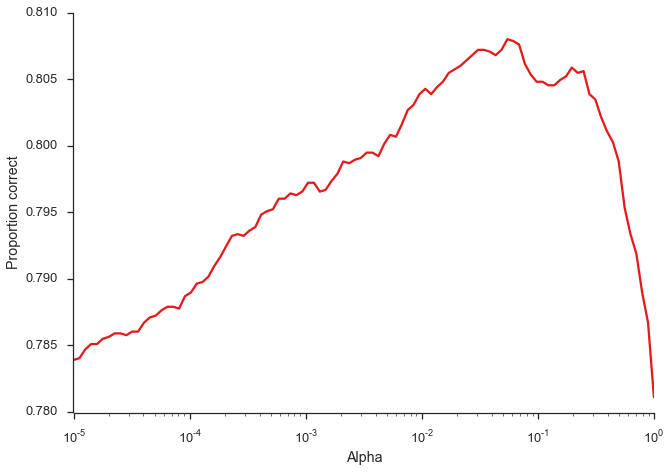

In [376]:
# multinomial naive bayes classifier on raw word counts
alpha = 1. / nwords
def MultinomialNB(X_train, X_test, alpha):
    pXgivY = np.zeros([nngs, nwords]) + alpha
    pY = np.zeros(nngs)
    for i in range(nngs):
        pXgivY[i, :] = pXgivY[i, :] + np.array(
            X_train[np.nonzero(y_train == i)[0], :].sum(axis=0))
        pXgivY[i, :] = pXgivY[i, :] / np.sum(pXgivY[i, :])
        pY[i] = np.sum(y_train == i)
    pY = pY / np.sum(pY)

    docprobs = X_test.dot(np.log(pXgivY.T)) + \
            np.tile(np.log(pY), [X_test.shape[0], 1])
    y_pred = np.argmax(docprobs, axis=1) 
    return(y_pred)

n = 100
preds_raw = np.zeros(n) 
alphas = 10. ** np.linspace(-5, 0, n)
for i, alpha in enumerate(alphas):
    preds_raw[i] = np.mean(MultinomialNB(X_train, X_test, alpha) == y_test)
    
plt.plot(alphas, preds, color=colors[0])
plt.semilogx()
plt.xlabel('Alpha')
plt.ylabel('Proportion correct')
sns.despine(offset=True)

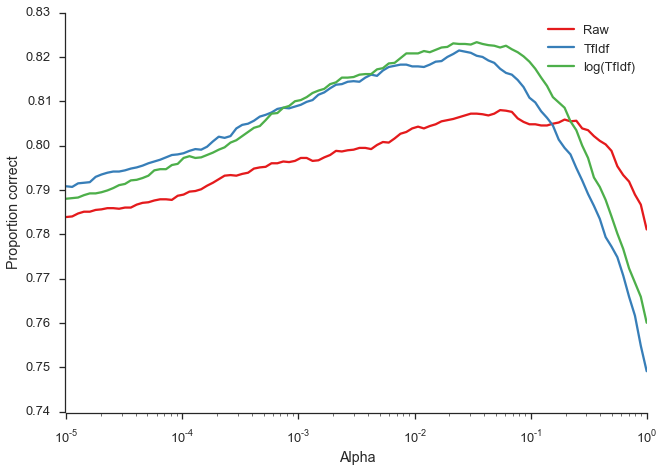

In [377]:
# multinomial naive bayes classifier on tfidf word counts
tfidf = TfidfTransformer(sublinear_tf=False)
tfidf.fit(sparse.vstack([X_train, X_test]))
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

preds_tfidf = np.zeros(n) 
for i, alpha in enumerate(alphas):
    preds_tfidf[i] = np.mean(
        MultinomialNB(X_train_tfidf, X_test_tfidf, alpha) == y_test)

# multinomial naive bayes classifier on log(tfidf) word counts
tfidf = TfidfTransformer(sublinear_tf=True)
tfidf.fit(sparse.vstack([X_train, X_test]))
X_train_tfidf_log = tfidf.transform(X_train)
X_test_tfidf_log = tfidf.transform(X_test)

preds_tfidf_log = np.zeros(n) 
for i, alpha in enumerate(alphas):
    preds_tfidf_log[i] = np.mean(
        MultinomialNB(X_train_tfidf_log, X_test_tfidf_log, alpha) == y_test)
    
plt.plot(alphas, preds_raw, color=colors[0])
plt.plot(alphas, preds_tfidf, color=colors[1])
plt.plot(alphas, preds_tfidf_log, color=colors[2])
plt.semilogx()
plt.legend(['Raw', 'TfIdf', 'log(TfIdf)'])
plt.xlabel('Alpha')
plt.ylabel('Proportion correct')
sns.despine(offset=True)

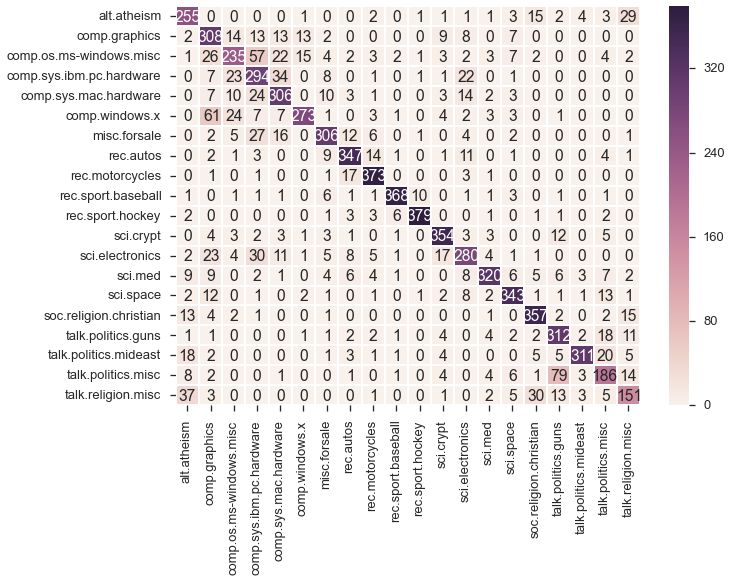

In [378]:
# confusion matrix from the best multinomial naive bayes classifier based on log tfidf counts
y_pred = MultinomialNB(X_train, X_test, alphas[np.argmax(preds_tfidf_log)])
df_conf = pd.DataFrame(confusion_matrix(y_test, y_pred),
                       index=nglabels.values(), columns=nglabels.values())
sns.heatmap(df_conf, annot=True, fmt='d', linewidth=0.5)


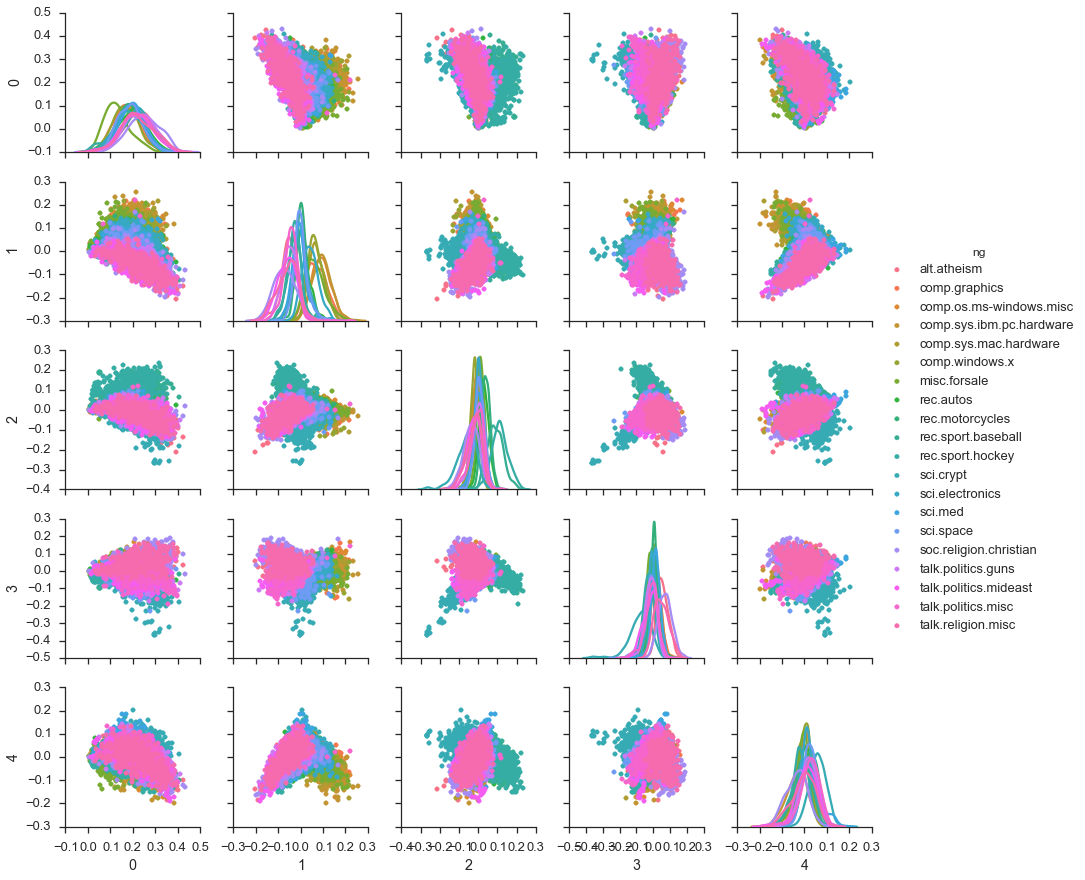

In [358]:
# LSA... can we see some clustering by newsgroup?

n_components = 5
tfidf = TfidfTransformer(sublinear_tf=True)
svd = TruncatedSVD(n_components=n_components)
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_train_svd = svd.fit_transform(X_train_tfidf)
df_train = pd.DataFrame(X_train_svd)
df_train['ng'] = [nglabels[i] for i in y_train]                               
g = sns.PairGrid(df_train, hue='ng', vars=np.arange(n_components))
g = g.map_offdiag(plt.scatter)
g = g.map_diag(sns.kdeplot, legend=False)
g.add_legend()


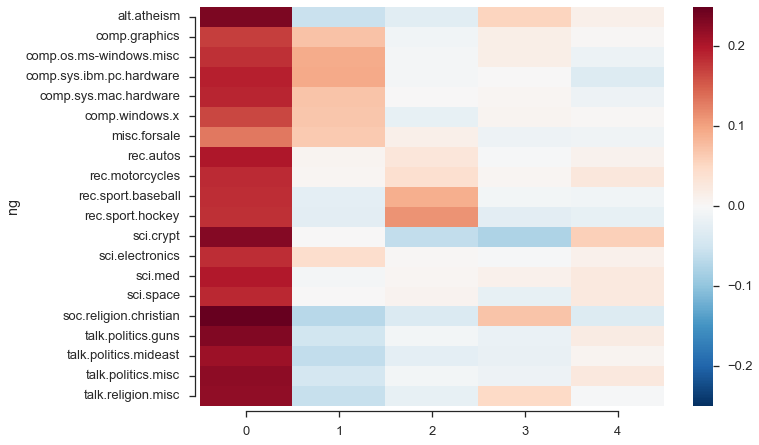

In [367]:
df_grouped=df_train.groupby(['ng']).mean()
g = sns.heatmap(df_grouped)
sns.despine(ax=g, offset=5, trim=True)

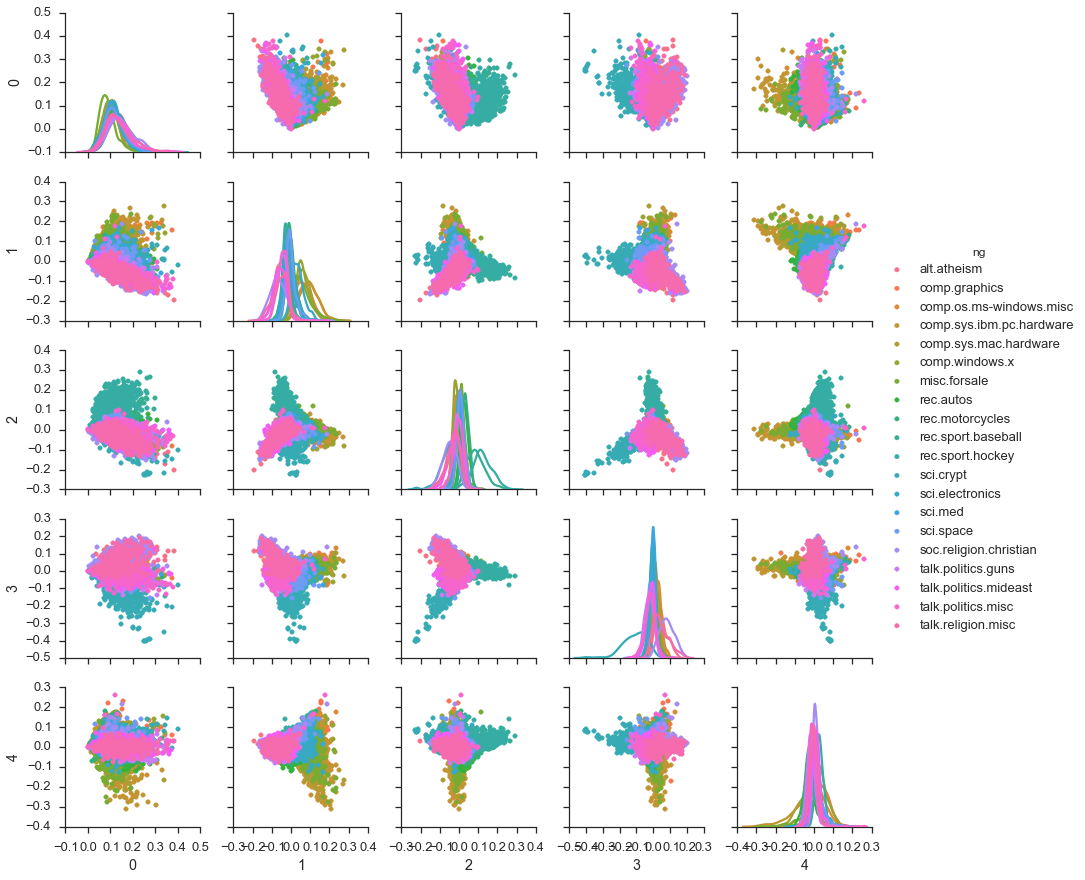

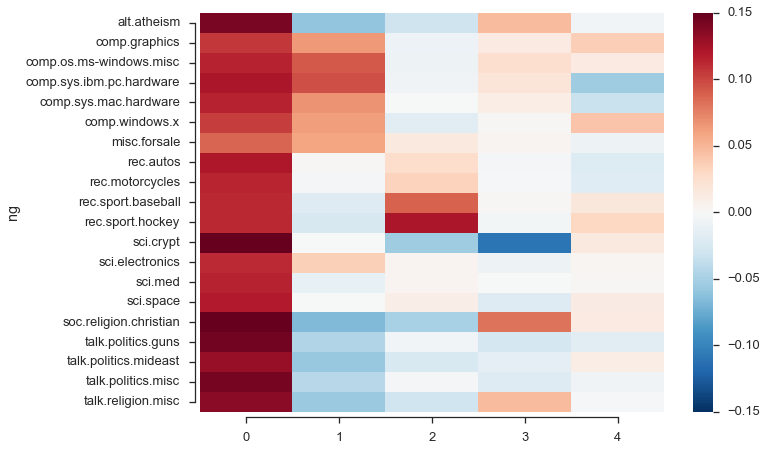

In [436]:
# Let's remove stop-words and redo LSA... perhaps a bit more discriminative?
from nltk.corpus import stopwords
stops = stopwords.words('english')
vocab_rev = {words: i for i, words in vocab.iteritems()}
remove_idx = [vocab_rev[s] for s in stops if s in vocab_rev]
keep_idx = set(vocab.keys()) - set(remove_idx)

vocab_nostop = {i: vocab[k] for i, k in enumerate(keep_idx)}
X_train_nostop = X_train[:, list(keep_idx)]
X_test_nostop = X_test[:, list(keep_idx)]

n_components=5
tfidf = TfidfTransformer(sublinear_tf=True)
svd = TruncatedSVD(n_components=n_components)
tfidf.fit(X_train_nostop)
X_train_tfidf_nostop = tfidf.transform(X_train_nostop)
X_test_tfidf_nostop = tfidf.transform(X_test_nostop)
X_train_svd_nostop = svd.fit_transform(X_train_tfidf_nostop)
df_train = pd.DataFrame(X_train_svd_nostop)
df_train['ng'] = [nglabels[i] for i in y_train]                               
g = sns.PairGrid(df_train, hue='ng', vars=np.arange(n_components))
g = g.map_offdiag(plt.scatter)
g = g.map_diag(sns.kdeplot, legend=False)
g.add_legend()

plt.figure()
df_grouped=df_train.groupby(['ng']).mean()
g = sns.heatmap(df_grouped)
sns.despine(ax=g, offset=5, trim=True)


In [432]:
# The second column seems to really discriminate between computer related newsgroups and more politically and
# religiously minded newgroups; let's see which words capture this distinction (words that contribute most
# positively and negatively to the component)
words = [vocab_nostop[idx] for idx in np.argsort(svd.components_[1, :])[-50:]][::-1]
print('Words that are common in computer but not political and religious newsgroups:\n')
print(words)
print('\n')
words = [vocab_nostop[idx] for idx in np.argsort(svd.components_[1, :])[0:50]]
print('Words that are common in political and religious newsgroups but not computer newsgroups:\n')
print(words)

Words that are common in computer but not political and religious newsgroups:

['thanks', 'windows', 'card', 'please', 'drive', 'dos', 'mail', 'anyone', 'mb', 'pc', 'advance', 'software', 'hi', 'use', 'email', 'file', 'video', 'disk', 'program', 'system', 'files', 'help', 'monitor', 'using', 'mac', 'scsi', 'computer', 'graphics', 'memory', 'looking', 'ram', 'ftp', 'need', 'info', 'controller', 'window', 'screen', 'running', 'appreciated', 'color', 'bus', 'drivers', 'problem', 'ms', 'mode', 'driver', 'version', 'mhz', 'ide', 'data']


Words that are common in political and religious newsgroups but not computer newsgroups:

['god', 'people', 'jesus', 'say', 'believe', 'think', 'us', 'said', 'writes', 'christians', 'government', 'even', 'bible', 'article', 'christian', 'christ', 'life', 'see', 'fact', 'jews', 'religion', 'law', 'many', 'faith', 'israel', 'evidence', 'right', 'truth', 'apr', 'world', 'man', 'children', 'church', 'years', 'agree', 'human', 'christianity', 'person', 'point',

In [433]:
# Let's do a similar analysis for the third column, which seems to discriminate sports and auto related news
# groups from religious ones
words = [vocab_nostop[idx] for idx in np.argsort(svd.components_[2, :])[-50:]][::-1]
print('Words that are common in sportsy but not religious newsgroups:\n')
print(words)
print('\n')
words = [vocab_nostop[idx] for idx in np.argsort(svd.components_[2, :])[0:50]]
print('Words that are common in religious but not sportsy newsgroups:\n')
print(words)

Words that are common in sportsy but not religious newsgroups:

['game', 'team', 'edu', 'games', 'year', 'season', 'hockey', 'play', 'ca', 'players', 'win', 'article', 'go', 'writes', 'baseball', 'last', 'league', 'teams', 'toronto', 'player', 'nhl', 'cup', 'apr', 'detroit', 'playoffs', 'pittsburgh', 'division', 'fan', 'mike', 'leafs', 'rangers', 'wings', 'fans', 'red', 'montreal', 'stanley', 'cs', 'good', 'chicago', 'boston', 'back', 'runs', 'car', 'got', 'best', 'series', 'st', 'hit', 'espn', 'next']


Words that are common in religious but not sportsy newsgroups:

['god', 'key', 'people', 'government', 'jesus', 'encryption', 'system', 'use', 'chip', 'christians', 'clipper', 'bible', 'christian', 'law', 'keys', 'public', 'religion', 'christ', 'must', 'using', 'escrow', 'faith', 'us', 'windows', 'believe', 'security', 'truth', 'christianity', 'cannot', 'human', 'jews', 'secure', 'data', 'life', 'church', 'information', 'non', 'example', 'question', 'israel', 'program', 'person', 'reli

In [435]:
# And the fourth column...which discriminates crypotgraphy from religious
words = [vocab_nostop[idx] for idx in np.argsort(svd.components_[3, :])[-50:]][::-1]
print('Words that are common in religious but not crypto newsgroups:\n')
print(words)
print('\n')
words = [vocab_nostop[idx] for idx in np.argsort(svd.components_[3, :])[0:50]]
print('Words that are common in crypto but not religious newsgroups:\n')
print(words)

Words that are common in religious but not crypto newsgroups:

['god', 'jesus', 'thanks', 'bible', 'christians', 'christian', 'edu', 'christ', 'faith', 'know', 'windows', 'anyone', 'rutgers', 'believe', 'please', 'christianity', 'church', 'card', 'hi', 'advance', 'religion', 'truth', 'drive', 'life', 'heaven', 'athos', 'belief', 'sin', 'lord', 'mb', 'say', 'love', 'atheists', 'says', 'eternal', 'word', 'dos', 'man', 'hell', 'sandvik', 'atheist', 'beliefs', 'think', 'atheism', 'true', 'scripture', 'problem', 'one', 'apple', 'book']


Words that are common in crypto but not religious newsgroups:

['key', 'encryption', 'government', 'clipper', 'chip', 'keys', 'escrow', 'public', 'secure', 'security', 'nsa', 'algorithm', 'privacy', 'system', 'enforcement', 'crypto', 'phone', 'secret', 'encrypted', 'clinton', 'data', 'pgp', 'communications', 'des', 'com', 'law', 'information', 'federal', 'technology', 'number', 'wiretap', 'use', 'agencies', 'president', 'administration', 'phones', 'access',

In [446]:
# Simple nearest neighbors classifier based on cosine similarity;
# Run time might be a few minutes
from scipy.stats import itemfreq
from sklearn.metrics.pairwise import cosine_similarity
n_neighbors = 2 ** np.arange(10)
n_components = 2 ** np.arange(3, 12)
all_perf = np.zeros([len(n_components), len(n_neighbors)])

for d, dim in enumerate(n_components):
    print('Testing ndim: {:d}'.format(dim))
    svd = TruncatedSVD(n_components=dim)
    X_train_svd = svd.fit_transform(X_train_tfidf_nostop)
    X_test_svd = svd.transform(X_test_tfidf_nostop)
    
    cos_sims = cosine_similarity(X_test_svd, X_train_svd)
    sorted_cos_sims = np.argsort(cos_sims, axis=1)
    neighbors = np.empty_like(sorted_cos_sims)
    for i in range(cos_sims.shape[0]):
        neighbors[i, :] = y_train[sorted_cos_sims[i, :]]
        
    perf = np.zeros(len(n_neighbors))
    for i, k in enumerate(n_neighbors):
        y_pred = np.zeros(sorted_cos_sims.shape[0])
        for trial in range(sorted_cos_sims.shape[0]):
            temp = itemfreq(neighbors[trial, -k:])
            winner = temp[:, 0][np.argmax(temp[:, 1])]
            y_pred[trial] = winner 
        perf[i] = np.mean(y_pred == y_test)
    all_perf[d, :] = perf

Testing ndim: 8
Testing ndim: 16
Testing ndim: 32
Testing ndim: 64
Testing ndim: 128
Testing ndim: 256
Testing ndim: 512
Testing ndim: 1024
Testing ndim: 2048


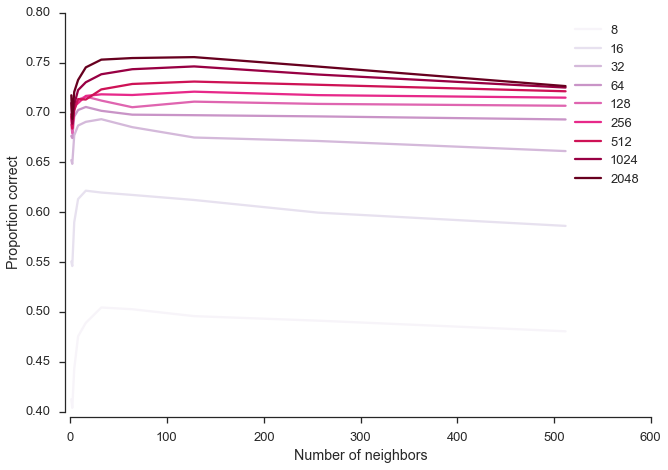

In [448]:
colors = b2mpl.get_map('PuRd', 'Sequential', len(n_components)).mpl_colors
for i in range(all_perf.shape[0]):
    plt.plot(n_neighbors, all_perf[i, :], color = colors[i])
plt.xlabel('Number of neighbors')
plt.ylabel('Proportion correct')
plt.legend(n_components)
sns.despine(offset=5, trim=True)